(rois:loading_2d)=

# Downloading ROIs (2D)

Of course, we do not only want to upload and store ROIs/segmentations/labels, but we may want to retrieve them for further processing. This tutorial shows how you can download ROIs from OMERO and turn them back into more convenient forms for downstream processing. For the sake of simplicity, we will work with the data that was segmented, labelled and uploaded to OMERO in the [previous tutorial](rois:saving_2d). Napari comes with some handy functionality to turn [shapes into labels data](https://napari.org/stable/gallery/shapes_to_labels.html), which we will make use of in this context.

For this tutorial, you'll have to install napari, too:

```bash
mamba install napari pyqt
```

In [7]:
from omero.model import Shape
from omero.rtypes import unwrap
from typing import Tuple

import ezomero
import napari
import numpy as np

In [ ]:
viewer = napari.Viewer()

Let's connect to our server:

In [4]:
user = 'your-user'
group = 'default'
host = 'your-host'
port = 4064
secure = True

conn = ezomero.connect(host=host, port=port, group=group, user=user, password=None, secure=secure)

Let's retrieve the image - check the OMERO browser to see the id of the uploaded image, as it will likely differ on your end.

<_ImageWrapper id=38008>
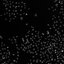

In [11]:
image_id = 38008

image_wrapper, image = ezomero.get_image(conn, image_id, dim_order='tczyx')
image_wrapper

Let's check what ROIs we find attached to this image. In our case, there are two ROIs. One for the binary mask and one for the labels image from the previous tutorial.

In [12]:
rois = image_wrapper.getROIs()
print(rois)

[<_RoiWrapper id=16194>, <_RoiWrapper id=16195>, <_RoiWrapper id=16196>]


## Binary masks

Let's start with the first by extracting the shapes from the ROI. We can then use the `mask_to_binary_image` from [omero-cli-zarr](https://github.com/ome/omero-cli-zarr) to convert it back to an image array, in this case to a boolean array. Unfortunately, this function is not readily available from the API of the package, so we copy and modify the function a bit for our purposes. (Note that this is not the most efficient way to do this, but it works for now.)

In [13]:
def mask_to_binary_image(
    mask: Shape, dtype=bool
) -> Tuple[np.ndarray, Tuple[int, ...]]:
    """
    Convert an OMERO mask to a binary image
    :param mask MaskI: An OMERO mask
    :param dtype: Data type for the binary image
    :return: tuple of
            - Binary mask
            - (T, C, Z, Y, X, w, h) tuple of mask settings (T, C, Z may be
            None)
    """

    t = unwrap(mask.theT)
    c = unwrap(mask.theC)
    z = unwrap(mask.theZ)

    x = int(mask.x.val)
    y = int(mask.y.val)
    w = int(mask.width.val)
    h = int(mask.height.val)

    mask_packed = mask.getBytes()
    # convert bytearray into something we can use
    intarray = np.fromstring(mask_packed, dtype=np.uint8)
    binarray = np.unpackbits(intarray).astype(dtype)
    # truncate and reshape
    binarray = np.reshape(binarray[: (w * h)], (h, w))

    return binarray, (t, c, z, y, x, h, w)

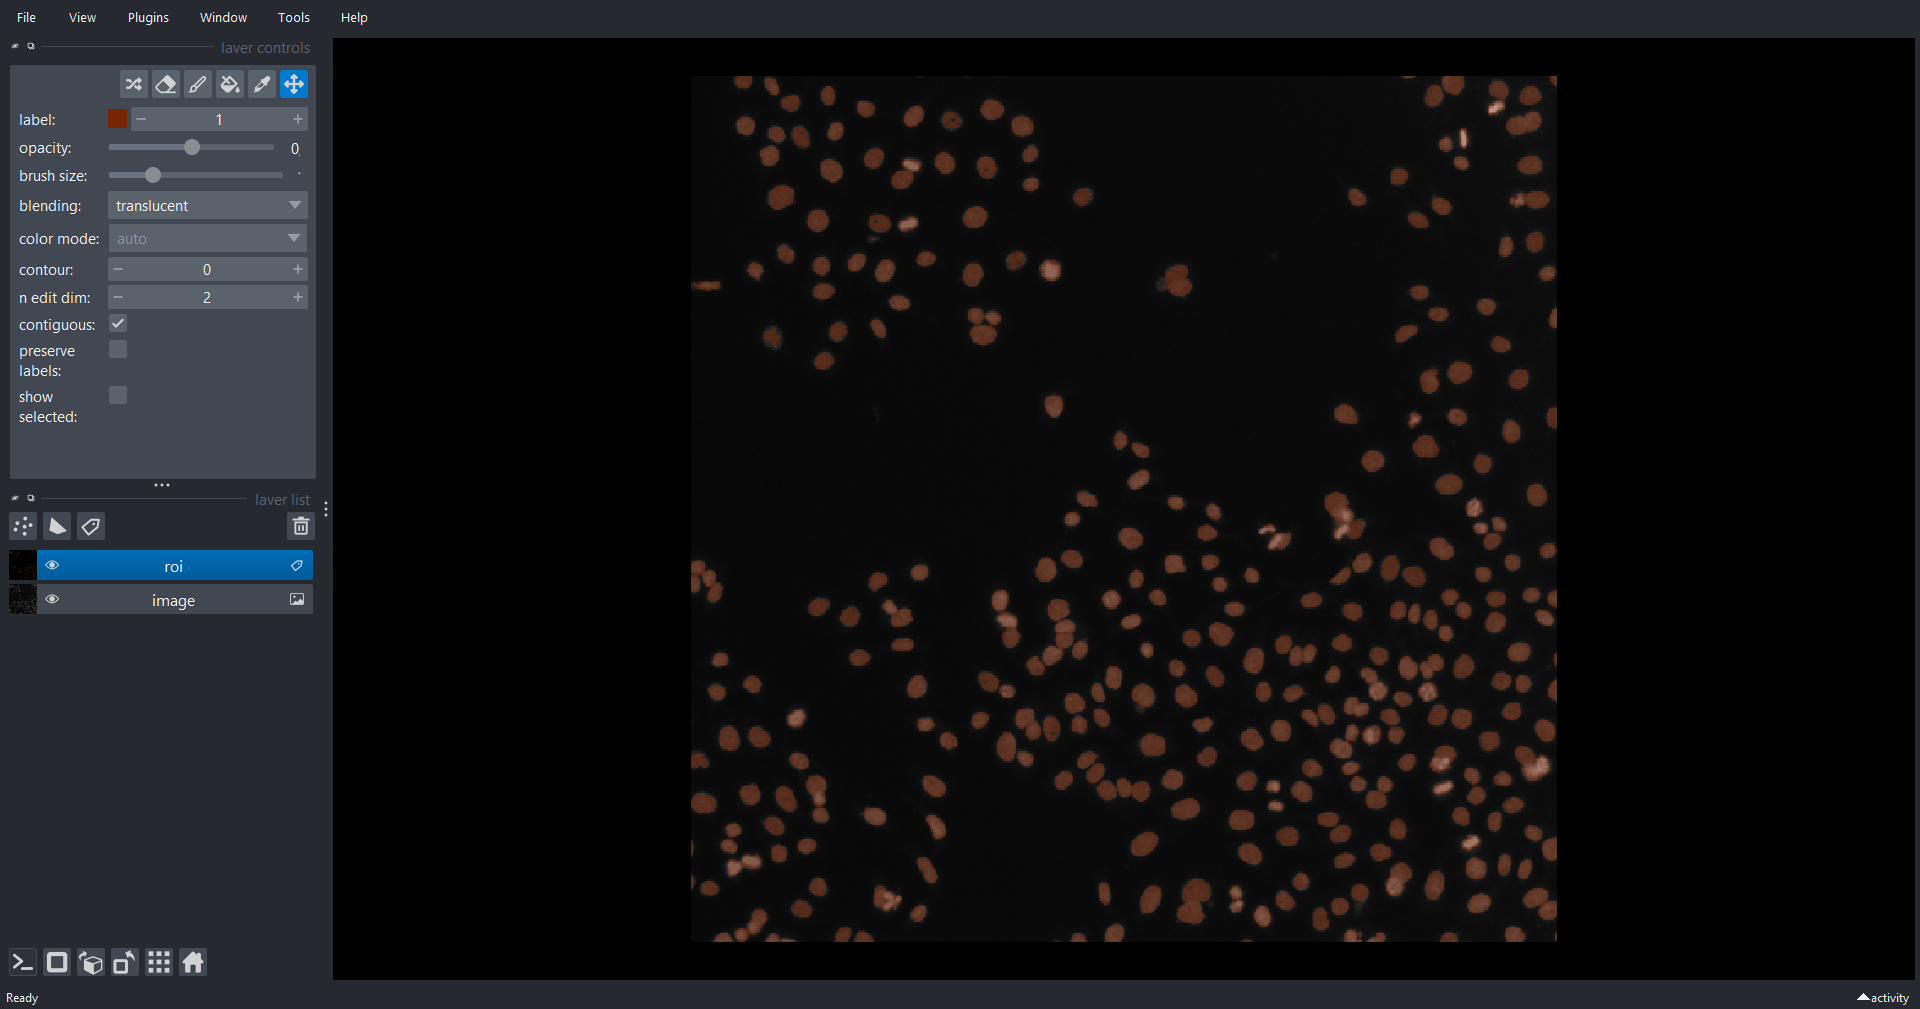

In [15]:
roi = rois[0]
shape = roi.copyShapes()[0]
array, metadata = mask_to_binary_image(shape)

viewer.layers.clear()
viewer.add_image(image.squeeze(), name='image')
viewer.add_labels(array.squeeze(), name='roi', opacity=0.5)
napari.utils.nbscreenshot(viewer)

## Labels images

Let's do the same with the labels data that we previously attached to this data. For this, we simply iterate through all the individual masks and add them to an empty copy of the input image:

In [16]:
roi = rois[1]
shapes = roi.copyShapes()

labels = np.zeros(image.shape, dtype=np.uint16).squeeze()
for idx, shape in enumerate(shapes):
    array, metadata = mask_to_binary_image(shape)
    y = metadata[3]
    x = metadata[4]
    h = metadata[5]
    w = metadata[6]

    mask = array == 1
    labels[y:y+h, x:x+w][mask] += (idx + 1)

Let's see what we get from this:

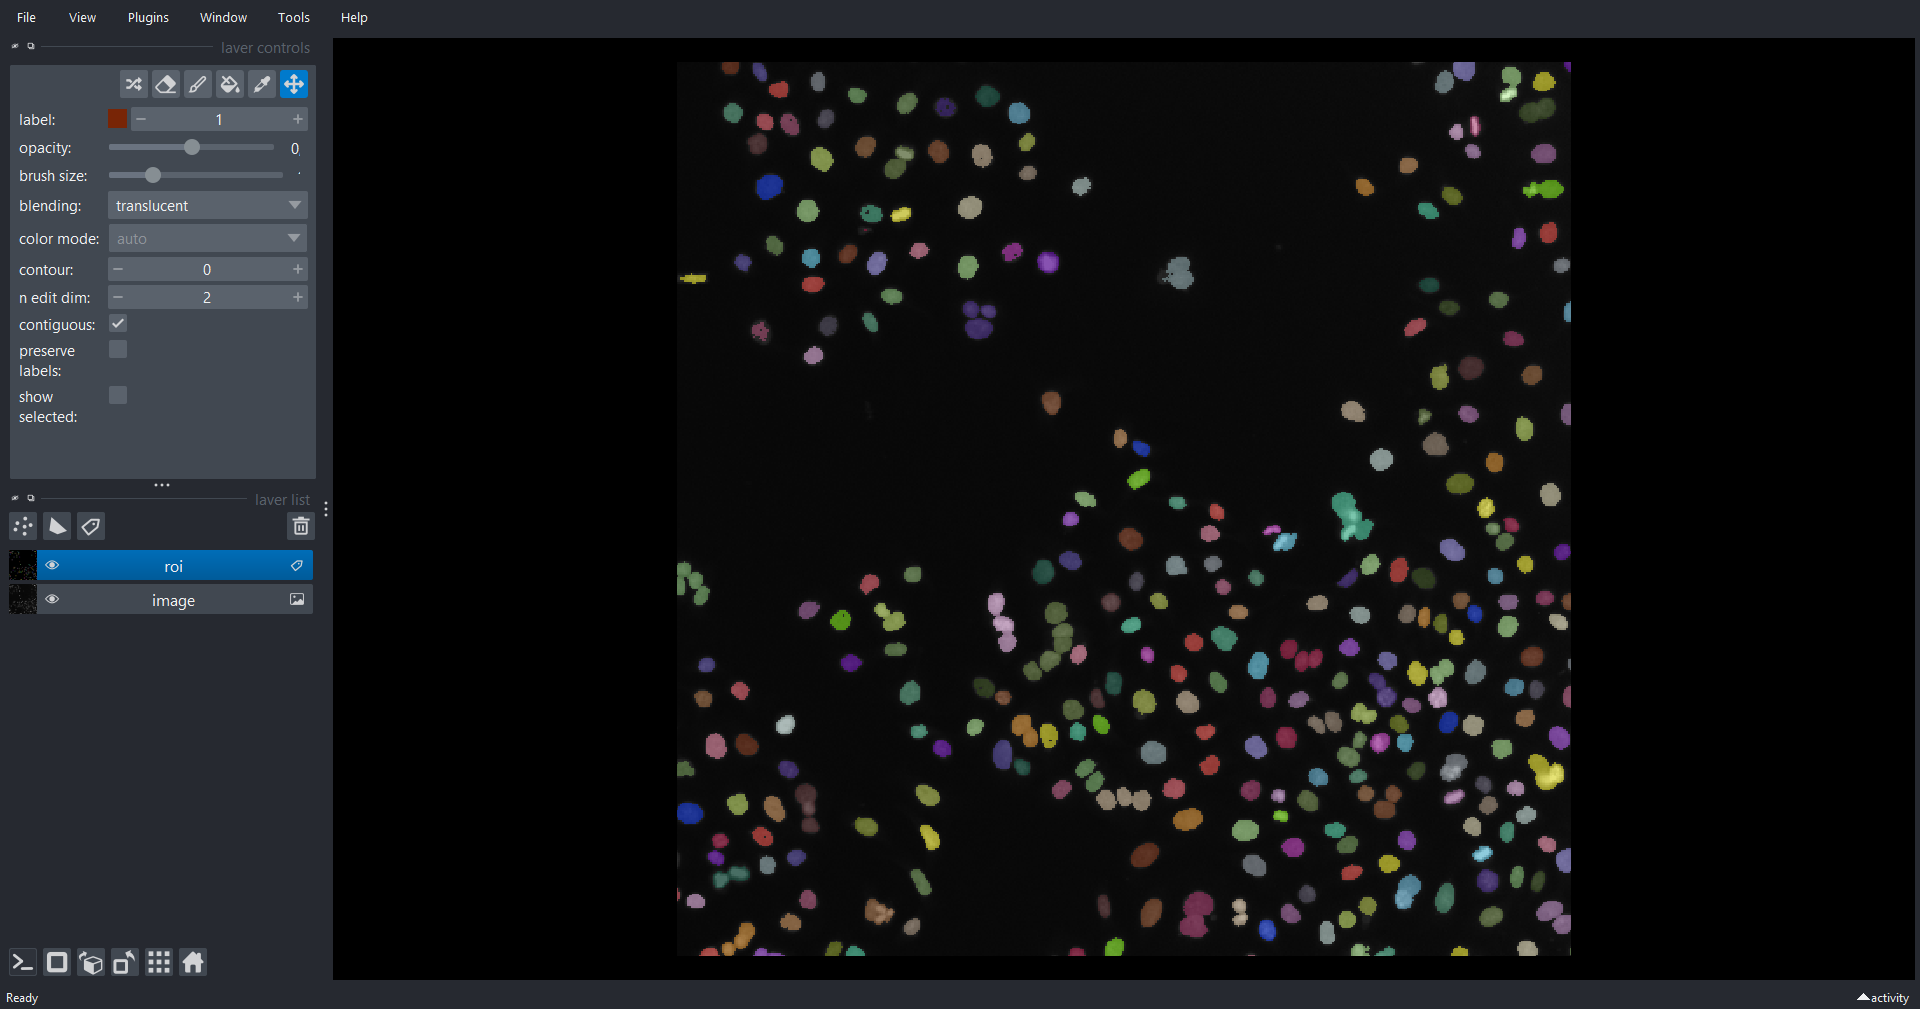

In [17]:
viewer.layers.clear()
viewer.add_image(image.squeeze(), name='image')
viewer.add_labels(labels.squeeze(), name='roi', opacity=0.5)
napari.utils.nbscreenshot(viewer)

There we go :)